# Assignment 1 - Prediction

<img src="https://i.imgur.com/EDdtZam.png" width=600 align="center">

# Contents
1. [Project Objectives](#1.-Project-Objectives) <br>
2. [What is the Naval Propulsion Plants dataset about?](#2.-What-is-the-Naval-Propulsion-Plants-dataset-about?)<br>
3. [Read This First](#3.-Read-This-First) <br>
4. [Data Exploration](#4.-Data-Exploration) <br>
5. [Prediction using Linear Regression](#5.-Prediction-using-Linear-Regression) <br> 
a. [Predicting Y1](#a.-Predicting-Y1) <br>
b. [Predicting Y2](#b.-Predicting-Y2) <br>
6. [Predicting Test Set](#6.-Predicting-Test-Set) <br> 
7. [References](#7.-References) <br>
8. [Grading Rubrics](#8.-Grading-Rubrics) <br>
9. [Using R in Jupyter Notebook](#9.-Using-R-in-Jupyter-Notebook) 

# 1. Project Objectives

In this assignment, the target is to predict the performance decay of the GT components such as GT Compressor and GT Turbine (two response variables) of a naval vessel, given 16 of its parameters (X1 to X16)

# 2. What is the Naval Propulsion Plants dataset about?

The experiments have been carried out by means of a numerical simulator of a naval vessel (Frigate) characterized by a Gas Turbine (GT) propulsion plant. The different blocks forming the complete simulator (Propeller, Hull, GT, Gear Box and Controller) have been developed and fine tuned over the year on several similar real propulsion plants. <br> <br>

The range of decay of compressor and turbine has been sampled with an uniform grid of precision 0.001 so to have a good granularity of representation. <br>
In particular for the compressor decay state discretization the kMc coefficient has been investigated in the domain [1; 0.95], and the turbine coefficient in the domain [1; 0.975].<br> 

<b>Link to original dataset:</b> http://archive.ics.uci.edu/ml/datasets/condition+based+maintenance+of+naval+propulsion+plants#

## Attribute Names 

X1 - Lever position (lp) [ ] <br>
X2 - Ship speed (v) [knots] <br>
X3 - Gas Turbine shaft torque (GTT) [kN m] <br>
X4 - Gas Turbine rate of revolutions (GTn) [rpm] <br>
X5 - Gas Generator rate of revolutions (GGn) [rpm] <br>
X6 - Starboard Propeller Torque (Ts) [kN] <br>
X7 - Port Propeller Torque (Tp) [kN] <br>
X8 - HP Turbine exit temperature (T48) [C] <br>
X9 - GT Compressor inlet air temperature (T1) [C] <br>
X10 - GT Compressor outlet air temperature (T2) [C] <br>
X11 - HP Turbine exit pressure (P48) [bar] <br>
X12 - GT Compressor inlet air pressure (P1) [bar] <br>
X13 - GT Compressor outlet air pressure (P2) [bar] <br>
X14 - Gas Turbine exhaust gas pressure (Pexh) [bar] <br>
X15 - Turbine Injecton Control (TIC) [%] <br>
X16 - Fuel flow (mf) [kg/s] <br>
Y1 - GT Compressor decay state coefficient. <br>
Y2 - GT Turbine decay state coefficient.

# 3. Read This First 

It can be quite hard to read code sometimes and to aid you in understanding my code and my process of thinking, <br> 
I have included my <b>explanation and thought process in <font color=green> green </font></b> and <b>weaved my insights and results in <font color=blue> blue </font> or as #comments. </font></b> 

### Importing libraries

In [1]:
options(warn=-1)

In [2]:
#install.packages("tidyverse")
#install.packages("corrplot")
#install.packages("rsample")
#install.packages("caret")
#install.packages("olsrr")

In [3]:
library(tidyverse)
library(corrplot)
library(rsample)
library(caret)
library(olsrr)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.2.1     v purrr   0.3.2
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
corrplot 0.84 loaded
Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift


Attaching package: 'olsrr'

The following object is masked from 'package:datasets':

    rivers



### Data Loading and Overview

<font color=green> We first load the data and observe the structure of the datasets we are provided

In [4]:
naval_training_data <- read.csv("assign1_NavalData.csv", header = TRUE)
str(naval_training_data)
naval_test_data <- read.csv("assign1_NavalPred.csv", header = TRUE)
str(naval_test_data)

'data.frame':	10000 obs. of  18 variables:
 $ X1 : num  3.14 7.15 5.14 4.16 9.3 9.3 2.09 1.14 8.21 8.21 ...
 $ X2 : int  9 21 15 12 27 27 6 3 24 24 ...
 $ X3 : num  8374 39007 21639 14722 72759 ...
 $ X4 : num  1387 2678 1924 1547 3560 ...
 $ X5 : num  7014 9116 8514 7758 9729 ...
 $ X6 : num  60.3 332.5 175.3 113.8 644.7 ...
 $ X7 : num  60.3 332.5 175.3 113.8 644.7 ...
 $ X8 : num  586 822 705 653 1058 ...
 $ X9 : int  288 288 288 288 288 288 288 288 288 288 ...
 $ X10: num  578 687 640 610 772 ...
 $ X11: num  1.39 2.99 2.07 1.66 4.55 4.52 1.33 1.26 3.6 3.58 ...
 $ X12: int  1 1 1 1 1 1 1 1 1 1 ...
 $ X13: num  7.6 15.71 10.92 9.01 22.96 ...
 $ X14: num  1.02 1.04 1.03 1.02 1.05 1.05 1.02 1.02 1.04 1.04 ...
 $ X15: num  12.3 44 24.9 17.8 88.3 ...
 $ X16: num  0.24 0.87 0.49 0.35 1.75 1.79 0.26 0.25 1.18 1.22 ...
 $ Y1 : num  0.99 0.99 0.95 0.97 1 0.97 0.99 0.99 1 0.96 ...
 $ Y2 : num  0.98 0.98 1 0.98 0.98 0.98 1 0.99 0.99 0.98 ...
'data.frame':	1000 obs. of  16 variables:
 $ X1 : n

<font color=blue> Here we can observe that the training dataset has 18 variables with 10000 rows while the test set has 16 variables with 1000 rows. All variables are either numeric or integer. 

## [Back to top](#Contents) 

# 4. Data Exploration

In [5]:
summary(naval_training_data)

       X1              X2              X3                X4      
 Min.   :1.140   Min.   : 3.00   Min.   :  253.6   Min.   :1308  
 1st Qu.:3.140   1st Qu.: 9.00   1st Qu.: 8375.9   1st Qu.:1387  
 Median :5.140   Median :15.00   Median :21630.7   Median :1924  
 Mean   :5.162   Mean   :14.98   Mean   :27160.0   Mean   :2134  
 3rd Qu.:7.150   3rd Qu.:21.00   3rd Qu.:39001.2   3rd Qu.:2678  
 Max.   :9.300   Max.   :27.00   Max.   :72783.3   Max.   :3561  
       X5             X6               X7               X8        
 Min.   :6589   Min.   :  5.30   Min.   :  5.30   Min.   : 444.7  
 1st Qu.:7058   1st Qu.: 60.32   1st Qu.: 60.32   1st Qu.: 590.0  
 Median :8482   Median :175.27   Median :175.27   Median : 706.0  
 Mean   :8198   Mean   :226.51   Mean   :226.51   Mean   : 734.9  
 3rd Qu.:9132   3rd Qu.:332.36   3rd Qu.:332.36   3rd Qu.: 833.6  
 Max.   :9797   Max.   :645.25   Max.   :645.25   Max.   :1115.8  
       X9           X10             X11             X12         X13  

<font color=blue> The summary here shows us that there is 0 NA values in all variables.

<font color=green> Let us also look at the no. of distinct values for each variable.

In [6]:
naval_training_data %>% summarise_all(n_distinct)

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,Y1,Y2
9,9,7443,2138,9346,1384,1384,8991,1,7377,60,1,509,4,3089,76,6,3


<font color=blue> The above shows that X9 and X12 only have 1 distinct value. As such, the inclusion of X9 and X12 is inconsequential to predicting Y1 & Y2. We can remove X9 and X12. 

<font color=green> X9 and X12 is removed and ```dim(naval_training_data)``` is used to confirm that the features have been removed.

In [7]:
naval_training_data <- select(naval_training_data, -c(9,12))
dim(naval_training_data)

[1] 10000    16

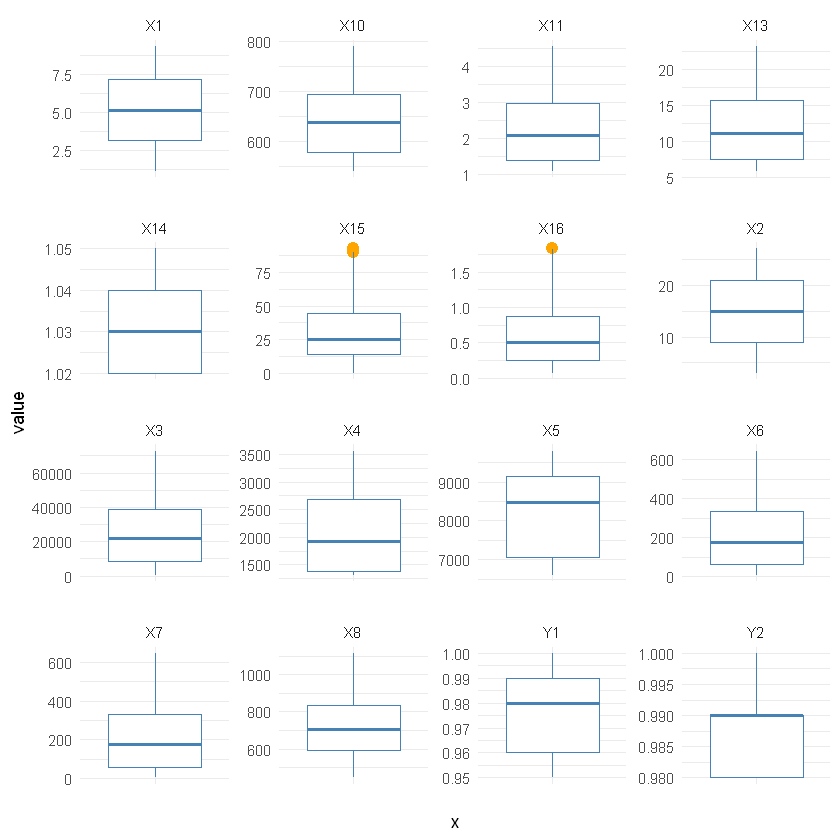

In [8]:
ggplot(gather(naval_training_data), aes(x = "", y = value)) + 
    geom_boxplot(color = "steelblue", outlier.size=3, outlier.color='orange') + 
    facet_wrap(~key, scales = 'free') + 
    theme_minimal()

<font color=blue> It looks like most of the features are distributed normally. There are outliers in X15 and X16. 

<font color=green> Below, we gather the data and observe the distributions of the predictor and target features using histograms. 

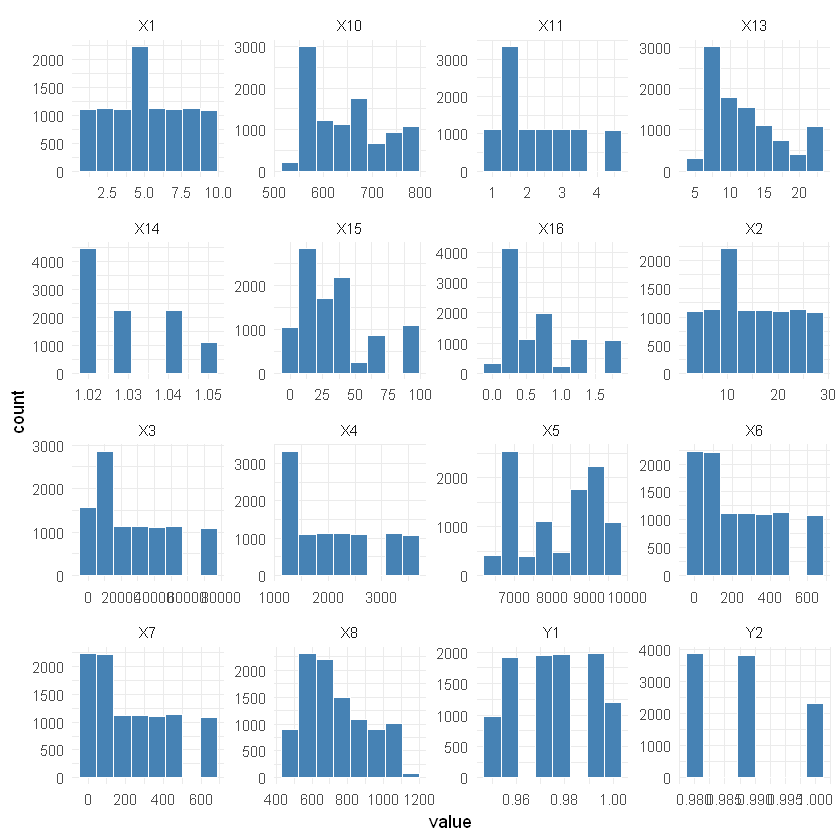

In [9]:
ggplot(gather(naval_training_data), aes(value)) + 
    geom_histogram(fill = "steelblue", bins = 8, col = "white") + 
    facet_wrap(~key, scales = 'free' ) +
    theme_minimal()

<font color=blue> Y1 and Y2 are not only numerical but distinct too. Let's observe the distribution of Y1 and Y2 closer on a kernel density plot. 

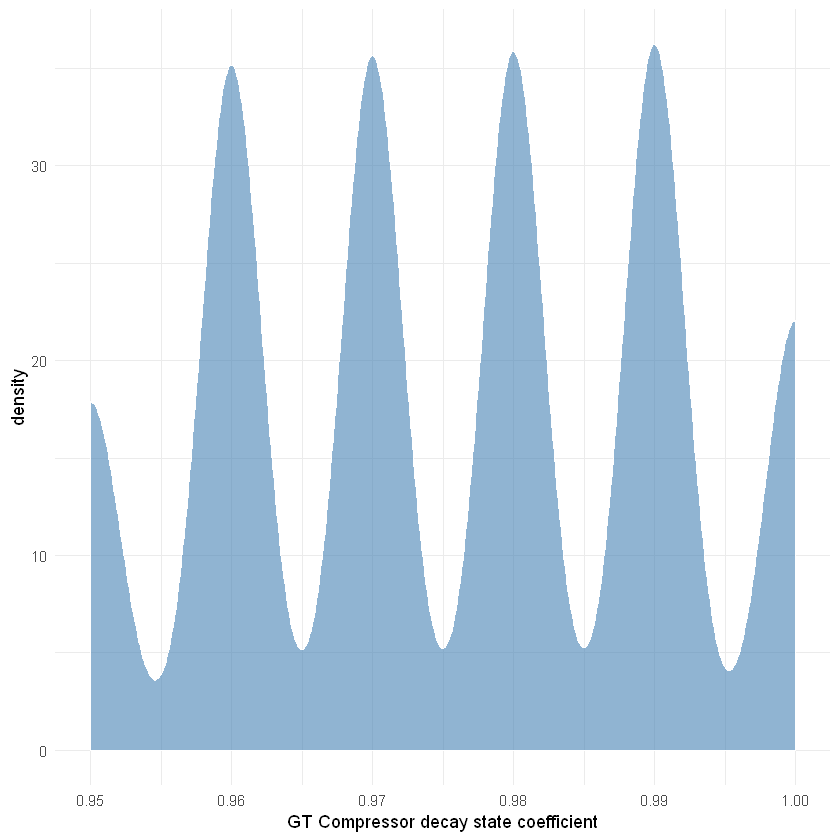

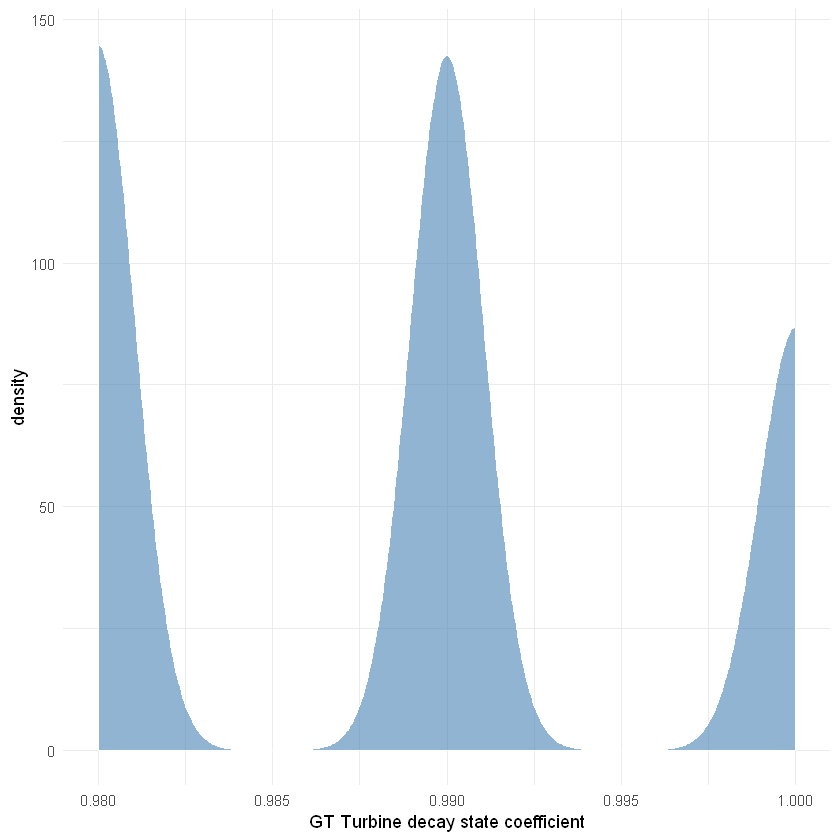

In [10]:
#Y1
ggplot(data = naval_training_data, aes(Y1)) + 
        geom_density(color = "white", fill = "steelblue", alpha = 0.6) + 
        scale_x_continuous(name = "GT Compressor decay state coefficient", breaks = c(.95, .96, .97, .98, .99, 1)) + 
        theme_minimal()
#Y2
ggplot(data = naval_training_data, aes(Y2)) + 
        geom_density(color = "white", fill = "steelblue", alpha = 0.6) + 
        scale_x_continuous(name = "GT Turbine decay state coefficient") +
        theme_minimal()

<font color=blue> The Gas Turbine Compressor state is being modeled as a performance decay state metric which is measured as 1 to 0, 1 meaning delivering 100% of the nominal performance. <br>

A quick glance shows us that Y1 and Y2 are distributed across 5 and 3 "categories".

In [11]:
sort(unique(naval_training_data$Y1))
sort(unique(naval_training_data$Y2))

[1] 0.95 0.96 0.97 0.98 0.99 1.00

[1] 0.98 0.99 1.00

<font color=blue> Further confirmation tells us that the values range from 0.95 to 1. <b>These values will be important in grouping the fitted values later</b>

,X1,X2,X3,X4,X5,X6,X7,X8,X10,X11,X13,X14,X15,X16,Y1,Y2
X1,1.000000000,0.999918932,0.961060859,0.962170527,0.986018461,0.959275784,0.959275784,0.96136311,0.98290152,0.963095924,0.969167929,0.939948005,0.91278119,0.93133395,-0.006831136,-0.004758308
X2,0.999918932,1.000000000,0.958307867,0.960416376,0.986548821,0.956445990,0.956445990,0.95897532,0.98129333,0.960647472,0.967014773,0.938787319,0.90918605,0.92776844,-0.006896537,-0.004737331
X3,0.961060859,0.958307867,1.000000000,0.989710627,0.932836760,0.999172632,0.999172632,0.99111711,0.99018396,0.998888416,0.997576076,0.972969659,0.97748359,0.99503535,-0.002047114,-0.004087297
X4,0.962170527,0.960416376,0.989710627,1.000000000,0.942750924,0.988613230,0.988613230,0.97960588,0.98921870,0.995108006,0.996031986,0.982595630,0.96199425,0.98019742,-0.003118643,-0.004376194
X5,0.986018461,0.986548821,0.932836760,0.942750924,1.000000000,0.929454314,0.929454314,0.93968908,0.96661694,0.937287676,0.945731565,0.930584897,0.87808002,0.89662692,-0.025153234,0.005878501
X6,0.959275784,0.956445990,0.999172632,0.988613230,0.929454314,1.000000000,1.000000000,0.98594120,0.98733461,0.997995101,0.996164013,0.972923822,0.97703954,0.99430721,-0.004261568,-0.004578771
X7,0.959275784,0.956445990,0.999172632,0.988613230,0.929454314,1.000000000,1.000000000,0.98594120,0.98733461,0.997995101,0.996164013,0.972923822,0.97703954,0.99430721,-0.004261568,-0.004578771
X8,0.961363106,0.958975323,0.991117108,0.979605879,0.939689075,0.985941204,0.985941204,1.00000000,0.99228188,0.989368313,0.990447825,0.961339751,0.96927553,0.98623588,-0.044284518,-0.039745766
X10,0.982901522,0.981293328,0.990183964,0.989218702,0.966616938,0.987334609,0.987334609,0.99228188,1.00000000,0.991669537,0.994336058,0.967675185,0.95811467,0.97630253,-0.051898504,-0.020041470
X11,0.963095924,0.960647472,0.998888416,0.995108006,0.937287676,0.997995101,0.997995101,0.98936831,0.99166954,1.000000000,0.999397450,0.978193788,0.97533481,0.99268366,0.002945739,-0.006871948


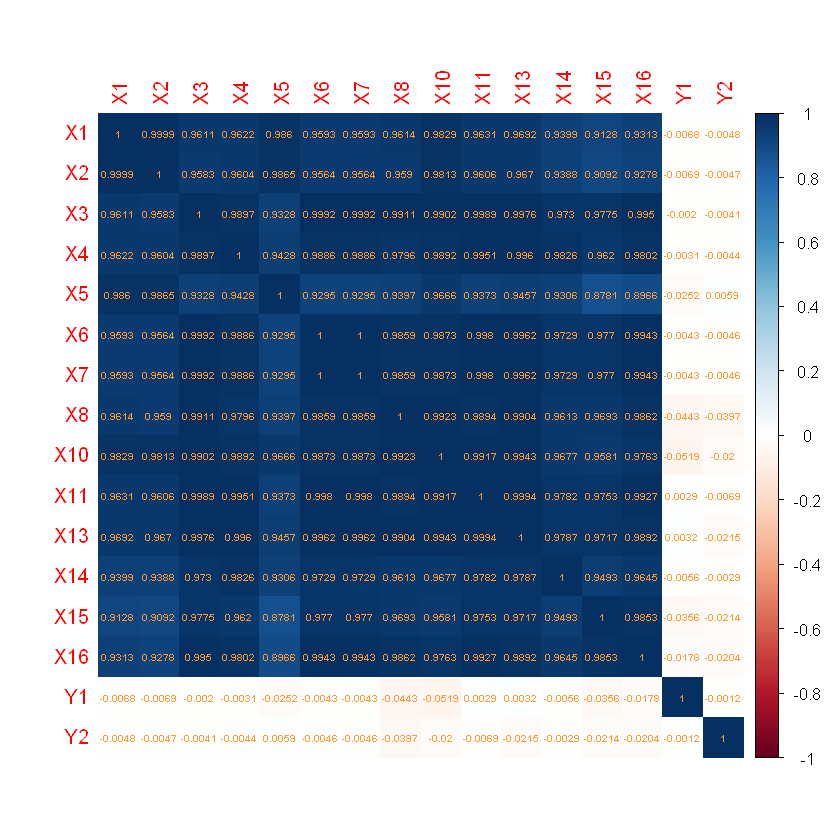

In [12]:
cor(naval_training_data)
corrplot(cor(naval_training_data), method="color", addCoef.col="#FF9933",number.digits = 4 , number.cex=0.5)

<font color=blue>None of the predictors have a strong correlation to the target variables. The above also shows us that all predictor variables are strongly correlated with each other. <b>This strongly indicates multicollinearity.</b> <p> However, the fact that some or all predictor variables are correlated among themselves <b>does
    not, in general, inhibit our ability to obtain a good fit</b> nor does it tend to affect inferences about mean responses or predictions of new observations, provided these inferences are made within the region of observations. <i>(Kutner, Nachtsheim, Neter, & Li, 2005) </i>Thus, we can use these variables to predict Y1 and Y2 </p> <br> <br>
    We also observe that <b>X6 and X7 have a correlation coefficient of 1</b>. Upon some googling of what a propeller torque is, we know that at any one time, the boat is only able to turn starboard (right) or port (left). Therefore, there is no need to keep both features. 

<font color = green>X7 is removed from dataframe

In [13]:
naval_training_data <- select(naval_training_data, -c(7))
names(naval_training_data)

[1] "X1"  "X2"  "X3"  "X4"  "X5"  "X6"  "X8"  "X10" "X11" "X13" "X14" "X15"
[13] "X16" "Y1"  "Y2"

## [Back to top](#Contents) 

# 5. Prediction using Linear Regression

<font color=green> To know whether the model fits the data well, we have to test the model. Hence, we first randomly order the data and then split the data into a ratio of 8:2. 80% of the data will be used as a training set while 20% is used as the test set. 

In [14]:
# Randomize data set
set.seed(42)
rows <- sample(nrow(naval_training_data))
naval_training_data <- naval_training_data[rows, ]

# We determine the row to split on and create the train and test set 
split <- round(nrow(naval_training_data) * 0.80)
train_data <- naval_training_data[1:split,]  
test_data <- naval_training_data[(split + 1):nrow(naval_training_data),]

# Confirm that data is split 8:2
nrow(train_data)
nrow(test_data)

[1] 8000

[1] 2000

# a. Predicting Y1

### Checking for non-linear relations with variables

<font color=green> We plot Y1 against all the other features. I used black as shades of gray are easier to differentiate to the eyes. ```geom_jitter()``` is a useful way of handling overplotting caused by the discreteness of Y1.   

In [15]:
train_data %>% 
    gather(-Y1, key = "var", value = "value") %>%
    ggplot(aes(x = value, y = Y1)) +  
    geom_jitter(color = "black", width = 0.5, alpha = 0.05) +
    facet_wrap(~ var, scales = "free") + 
    theme_minimal() +
    xlab("Predictor") +
    ylab("Y1") + 
    labs(title = 'Y1 against predictors', 
         caption = "Y1 = GT Compressor decay state coefficient")

<font color=blue> Plotting Y1 against all the other predictors shows us barely any information that we can use for feature selection. 

### Modelling

<font color=green> One way of selecting features is to pick all the features first. We model the data using all the variables we have as well as the independent squared variables. 

In [38]:
base_Y1_model <- lm(Y1 ~ . + I(X1^2) + I(X2^2) + I(X3^2) + I(X4^2) + I(X5^2) + 
                    I(X6^2) + I(X8^2) + I(X10^2) + I(X11^2) + I(X13^2) + 
                    I(X14^2) + I(X16^2) - X11,
                    data = train_data)
summary(base_Y1_model)


Call:
lm(formula = Y1 ~ . + I(X1^2) + I(X2^2) + I(X3^2) + I(X4^2) + 
    I(X5^2) + I(X6^2) + I(X8^2) + I(X10^2) + I(X11^2) + I(X13^2) + 
    I(X14^2) + I(X16^2) - X11, data = train_data)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0066699 -0.0024126  0.0000083  0.0024150  0.0072459 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -6.117e+02  3.028e+01 -20.204  < 2e-16 ***
X1           4.340e-01  7.157e-02   6.064 1.39e-09 ***
X2          -1.438e-01  2.179e-02  -6.601 4.34e-11 ***
X3           4.645e-06  9.692e-07   4.792 1.68e-06 ***
X4           8.700e-04  6.102e-05  14.259  < 2e-16 ***
X5           2.038e-04  2.218e-05   9.188  < 2e-16 ***
X6          -5.980e-04  7.348e-05  -8.139 4.60e-16 ***
X8           1.026e-03  1.390e-04   7.381 1.73e-13 ***
X10         -1.264e-02  5.946e-04 -21.261  < 2e-16 ***
X13          5.418e-02  6.581e-03   8.232  < 2e-16 ***
X14          1.205e+03  5.945e+01  20.276  < 2e-16 ***
X15         -

<font color=blue> The R-squared value is > 0.96. This could indicate that we are overfitting the model. Therefore, let's remove the variables that contributes towards our RMSE value. 

### Advanced linear regression 

<font color = green> <b>To choose the best regression model, we use stepwise regression</b> which helps us select a model by automatically adding or removing individual predictors, a step at a time, based on their statistical significance. The end result of this process is a single regression model, which makes it nice and simple.

In [39]:
ols_step_forward_p(base_Y1_model)


                               Selection Summary                                 
--------------------------------------------------------------------------------
        Variable                  Adj.                                              
Step    Entered     R-Square    R-Square       C(p)            AIC         RMSE     
--------------------------------------------------------------------------------
   1    I(X10^2)      0.0031      0.0030    206241.3325    -44163.1089    0.0153    
   2    X3            0.5261      0.5258     93850.2438    -50104.6987    0.0106    
   3    X13           0.9599      0.9598       670.9087    -69820.6944    0.0031    
   4    I(X1^2)       0.9625      0.9624        98.7900    -70369.6354    0.0030    
   5    I(X2^2)       0.9628      0.9627        42.6993    -70425.5545    0.0030    
   6    X1            0.9629      0.9628        24.3235    -70443.9698    0.0030    
   7    X2                NA          NA             NA             NA     

<font color =green> We select steps 1-6 as the variables in our new model. 

In [40]:
new_model <- lm(Y1 ~ I(X10^2) +
               X3 + 
               X13 + 
               I(X1^2) + 
               I(X2^2) + 
               X1, 
               data = train_data)

In [41]:
summary(new_model)


Call:
lm(formula = Y1 ~ I(X10^2) + X3 + X13 + I(X1^2) + I(X2^2) + X1, 
    data = train_data)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0250778 -0.0065384 -0.0001071  0.0066798  0.0235674 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.285e+00  4.350e-03  295.43   <2e-16 ***
I(X10^2)    -1.942e-06  1.479e-08 -131.31   <2e-16 ***
X3          -1.435e-06  1.202e-07  -11.94   <2e-16 ***
X13          4.344e-02  5.598e-04   77.60   <2e-16 ***
I(X1^2)      1.256e-02  4.953e-04   25.35   <2e-16 ***
I(X2^2)     -1.691e-03  5.519e-05  -30.64   <2e-16 ***
X1           1.481e-02  2.230e-04   66.42   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.008475 on 7993 degrees of freedom
Multiple R-squared:  0.6946,	Adjusted R-squared:  0.6944 
F-statistic:  3030 on 6 and 7993 DF,  p-value: < 2.2e-16


<font color =green> We eliminate outliers in our dataset and update the model as ```clean_Y1_model```.

In [42]:
cd <- cooks.distance(new_model)
train_data.clean <- train_data[abs(cd) < 4/nrow(train_data), ]
nrow(train_data.clean)

[1] 7605

In [43]:
formula(new_model)
clean_Y1_model <- lm(formula(new_model), data = train_data.clean)

Y1 ~ I(X10^2) + X3 + X13 + I(X1^2) + I(X2^2) + X1

In [44]:
summary(clean_Y1_model)


Call:
lm(formula = formula(new_model), data = train_data.clean)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.021142 -0.005881 -0.000150  0.005871  0.018700 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.297e+00  3.966e-03  327.12   <2e-16 ***
I(X10^2)    -2.096e-06  1.434e-08 -146.09   <2e-16 ***
X3          -2.472e-06  1.127e-07  -21.94   <2e-16 ***
X13          4.906e-02  5.532e-04   88.68   <2e-16 ***
I(X1^2)      1.821e-02  4.684e-04   38.87   <2e-16 ***
I(X2^2)     -2.329e-03  5.232e-05  -44.51   <2e-16 ***
X1           1.554e-02  2.146e-04   72.44   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.007659 on 7598 degrees of freedom
Multiple R-squared:  0.7427,	Adjusted R-squared:  0.7425 
F-statistic:  3655 on 6 and 7598 DF,  p-value: < 2.2e-16


<font color =blue> A marked increase in R-squared value for our new cleaned model. All significant variables are included in this model. 

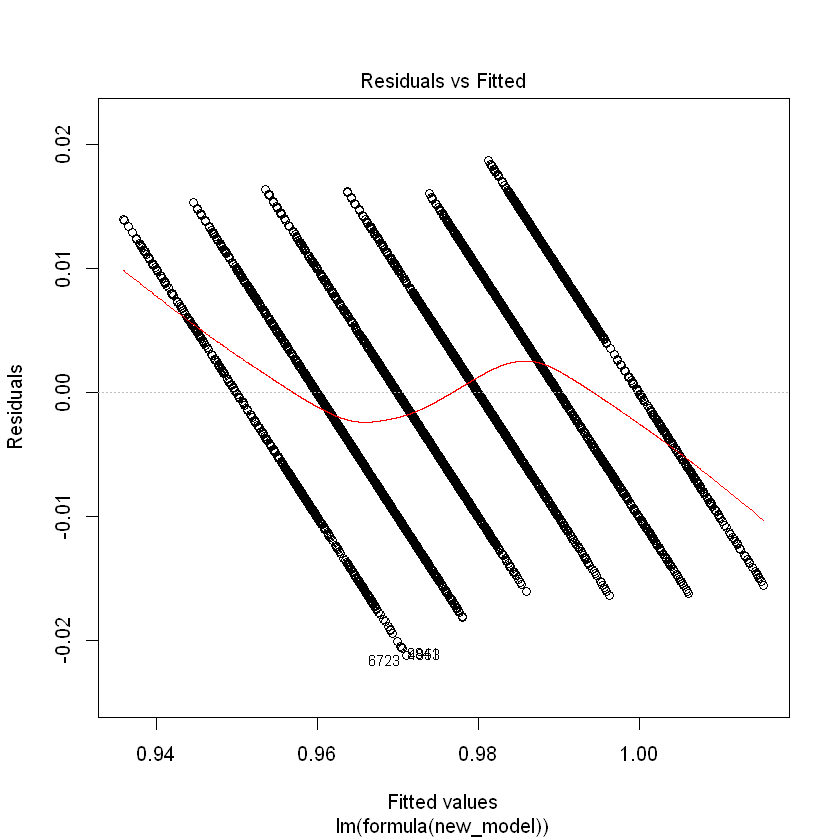

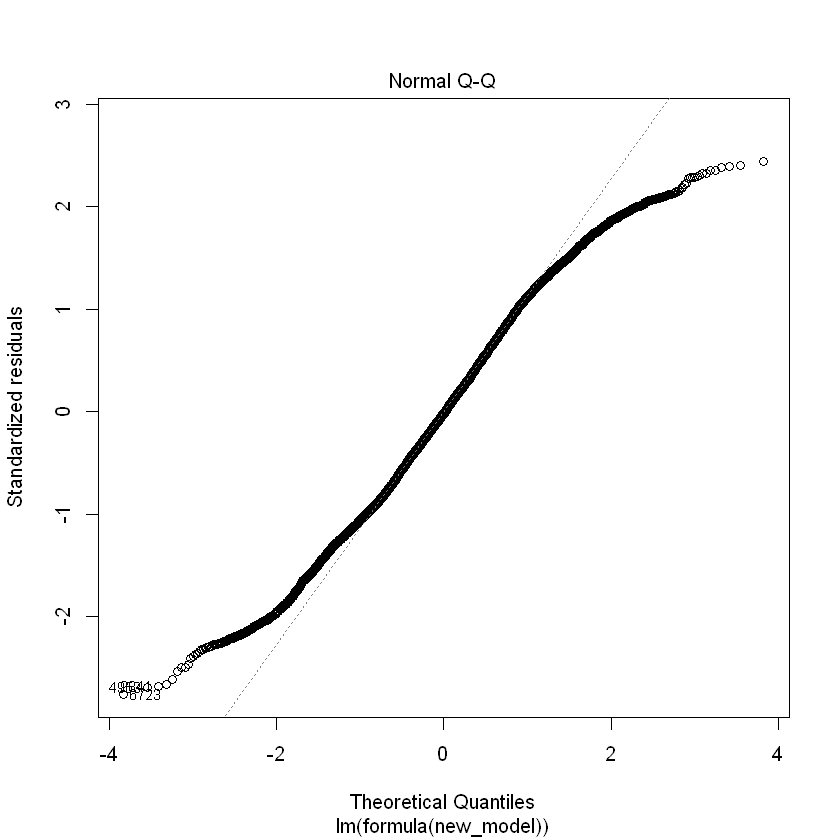

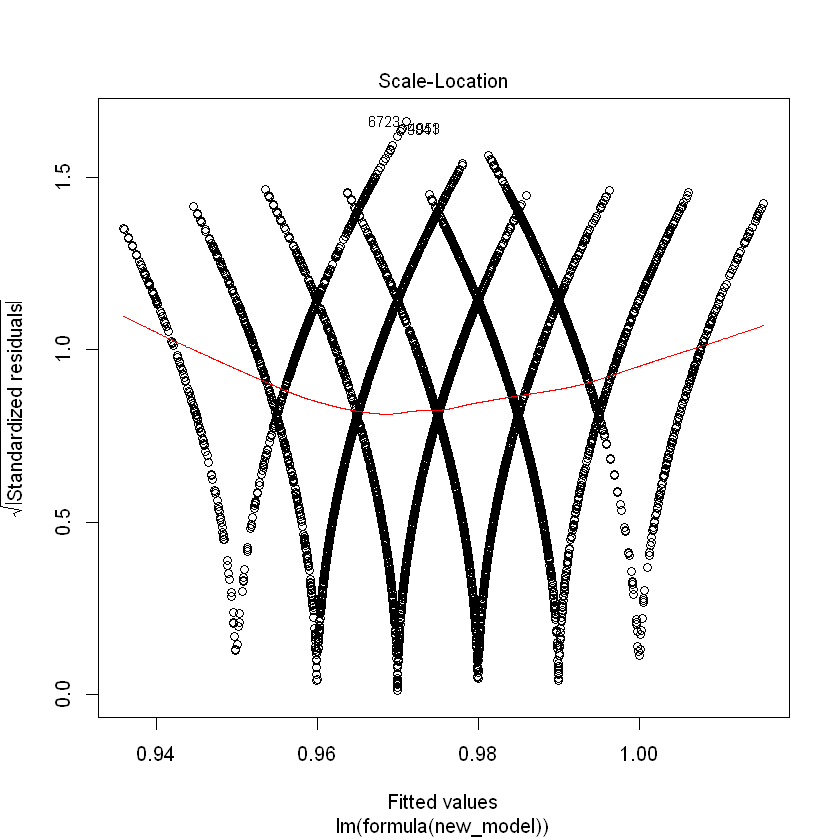

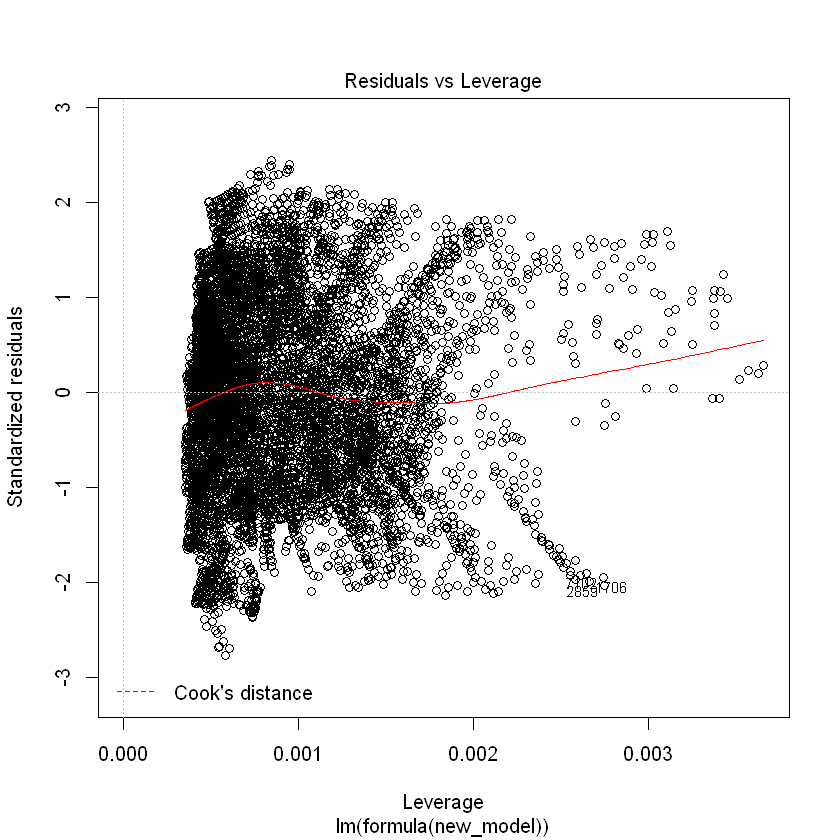

In [45]:
plot(clean_Y1_model)

<font color=blue>The discrete values of Y2 makes it difficult to observe if the values follow the model closely. However, we can still observe that most residuals have a low leverage in the Residuals vs Leverage graph.

<font color =green> Now we predict the values in ```test_data``` using ```clean_Y1_model```

In [46]:
test_data$Predicted <- predict(clean_Y1_model, newdata = test_data)
head(test_data)

,X1,X2,X3,X4,X5,X6,X8,X10,X11,X13,X14,X15,X16,Y1,Y2,Predicted,group_predicted
9782,3.14,9,8381.37,1386.77,7166.29,60.38,588.87,584.45,1.39,7.42,1.02,12.38,0.25,0.95,1.00,0.9646088,0.99
1719,2.09,6,4535.72,1393.74,6759.03,31.38,542.95,564.39,1.27,6.87,1.02,0.00,0.18,0.99,0.98,0.9839161,0.97
5075,1.14,3,2054.99,1310.52,6685.21,5.42,526.79,556.07,1.16,6.23,1.02,29.69,0.18,0.96,0.99,0.9704276,0.98
9835,5.14,15,21639.28,1924.34,8510.34,175.31,714.83,642.55,2.07,11.00,1.03,25.42,0.50,0.95,0.99,0.9553353,0.99
7172,4.16,12,14718.51,1547.45,7721.69,113.74,631.69,602.81,1.66,8.94,1.02,16.83,0.33,0.99,0.99,0.9825476,0.97
3437,9.30,27,72779.21,3560.41,9770.42,644.99,1069.23,777.39,4.50,22.34,1.05,88.34,1.75,0.97,1.00,0.9687055,0.98


<font color =green>As the Y1 values are discrete numerical values, the predicted Y1 values will need to be binned into the 6 discrete values (1, 0.99, 0.98, 0.97, 0.96, 0.95)

In [47]:
max <- max(test_data$Predicted)
min <- min(test_data$Predicted)

interval <- (max(test_data$Predicted) - min(test_data$Predicted)) / 6
range <- c(1, 0.99, 0.98, 0.97, 0.96, 0.95)
X = rep(0,6)
for (i in 1:6) {
    X[i] = max - interval*i
}
X <- append(X, 1.2)
X
range
test_data$group_predicted <- as.numeric(as.character(cut(test_data$Predicted, breaks = X, labels = range)))

[1] 1.0085530 0.9938436 0.9791341 0.9644246 0.9497152 0.9350057 1.2000000

[1] 1.00 0.99 0.98 0.97 0.96 0.95

<font color =green>```postResample()``` from the caret package is used to calculate the Rsquared value and RMSE 

In [48]:
postResample(pred = test_data$group_predicted, obs = test_data$Y1)

RMSE   Rsquared        MAE 
0.02324909 0.60478260 0.01962481

<font color =blue> The RMSE value indicates the absolute fit of the model to the data–how close the observed data points are to the model’s predicted values. <br> Despite the R squared value of 0.6, <b>achieving a RMSE value of 0.0232 means that the data points are close to the model's predicted values</b>. Therefore, we can use this model to predict the test dataset. 

## [Back to top](#Contents) 

# b. Predicting Y2

### Modelling

<font color=green> We repeat the same steps for predicting Y2. 

In [26]:
base_Y2_model <- lm(Y2 ~ X1 + X2 + X3 + X4 + X5 + X6 + X8 + X10 + X11 + X13 + X14 + 
                    X15 + X16 - Y2 + 
                    I(X1^2) +
                    I(X2^2) + 
                    I(X3^2) + 
                    I(X4^2) + 
                    I(X5^2) + 
                    I(X6^2) + 
                    I(X8^2) + 
                    I(X10^2) + 
                    I(X11^2) + 
                    I(X13^2) + 
                    I(X14^2) + 
                    I(X16^2) - 
                    X11,
                data = train_data)
summary(base_Y2_model)


Call:
lm(formula = Y2 ~ X1 + X2 + X3 + X4 + X5 + X6 + X8 + X10 + X11 + 
    X13 + X14 + X15 + X16 - Y2 + I(X1^2) + I(X2^2) + I(X3^2) + 
    I(X4^2) + I(X5^2) + I(X6^2) + I(X8^2) + I(X10^2) + I(X11^2) + 
    I(X13^2) + I(X14^2) + I(X16^2) - X11, data = train_data)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0066256 -0.0022548  0.0002556  0.0023071  0.0068754 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.244e+02  2.873e+01   7.811 6.41e-15 ***
X1          -8.694e-01  6.748e-02 -12.885  < 2e-16 ***
X2           2.723e-01  2.053e-02  13.262  < 2e-16 ***
X3           2.160e-05  8.910e-07  24.246  < 2e-16 ***
X4          -4.715e-04  5.788e-05  -8.145 4.36e-16 ***
X5           3.004e-04  2.086e-05  14.402  < 2e-16 ***
X6           3.575e-05  7.000e-05   0.511   0.6096    
X8           2.178e-04  1.324e-04   1.645   0.1001    
X10         -5.806e-03  5.627e-04 -10.319  < 2e-16 ***
X13         -1.082e-01  6.151e-03 -17.597  < 2

### Advanced linear regression

<font color=green> I couldn't get the ```ols_step_forward_p()``` function to work. There seems to be a fundamental error. ```ols_step_backward_p()``` is used instead. It is almost the same thing but tells you which variables to eliminate from your model.

In [27]:
ols_step_backward_p(base_Y2_model)



                            Elimination Summary                              
----------------------------------------------------------------------------
        Variable                  Adj.                                          
Step    Removed     R-Square    R-Square     C(p)          AIC         RMSE     
----------------------------------------------------------------------------
   1    X6            0.8669      0.8665    23.2608    -71221.7581    0.0028    
----------------------------------------------------------------------------

In [28]:
new_Y2_model <- lm(Y2 ~ X1 + X2 + X3 + X4 + X5 + X8 + X10 + X11 + X13 + X14 + 
                    X15 + X16 - Y2 + 
                    I(X1^2) +
                    I(X2^2) + 
                    I(X3^2) + 
                    I(X4^2) + 
                    I(X5^2) + 
                    I(X6^2) + 
                    I(X8^2) + 
                    I(X10^2) + 
                    I(X11^2) + 
                    I(X13^2) + 
                    I(X14^2) + 
                    I(X16^2) - 
                    X11,
                data = train_data)
summary(base_Y2_model)


Call:
lm(formula = Y2 ~ X1 + X2 + X3 + X4 + X5 + X6 + X8 + X10 + X11 + 
    X13 + X14 + X15 + X16 - Y2 + I(X1^2) + I(X2^2) + I(X3^2) + 
    I(X4^2) + I(X5^2) + I(X6^2) + I(X8^2) + I(X10^2) + I(X11^2) + 
    I(X13^2) + I(X14^2) + I(X16^2) - X11, data = train_data)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0066256 -0.0022548  0.0002556  0.0023071  0.0068754 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.244e+02  2.873e+01   7.811 6.41e-15 ***
X1          -8.694e-01  6.748e-02 -12.885  < 2e-16 ***
X2           2.723e-01  2.053e-02  13.262  < 2e-16 ***
X3           2.160e-05  8.910e-07  24.246  < 2e-16 ***
X4          -4.715e-04  5.788e-05  -8.145 4.36e-16 ***
X5           3.004e-04  2.086e-05  14.402  < 2e-16 ***
X6           3.575e-05  7.000e-05   0.511   0.6096    
X8           2.178e-04  1.324e-04   1.645   0.1001    
X10         -5.806e-03  5.627e-04 -10.319  < 2e-16 ***
X13         -1.082e-01  6.151e-03 -17.597  < 2

In [29]:
cd <- cooks.distance(new_Y2_model)
formula(new_Y2_model)
clean_Y2_model <- lm(formula(new_Y2_model), data = train_data.clean)

Y2 ~ X1 + X2 + X3 + X4 + X5 + X8 + X10 + X11 + X13 + X14 + X15 + 
    X16 - Y2 + I(X1^2) + I(X2^2) + I(X3^2) + I(X4^2) + I(X5^2) + 
    I(X6^2) + I(X8^2) + I(X10^2) + I(X11^2) + I(X13^2) + I(X14^2) + 
    I(X16^2) - X11

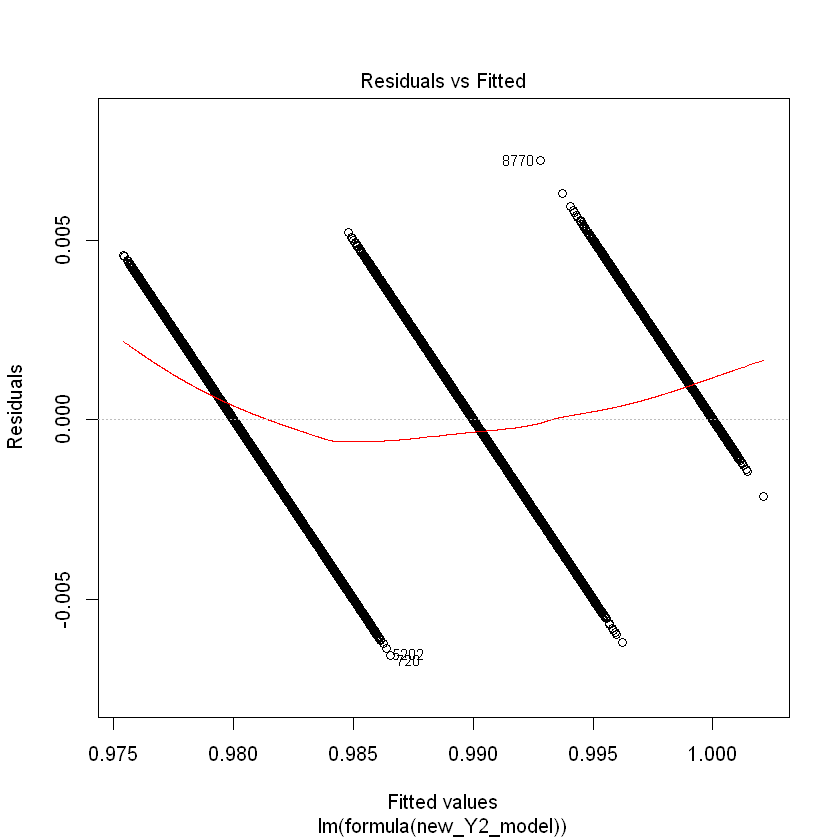

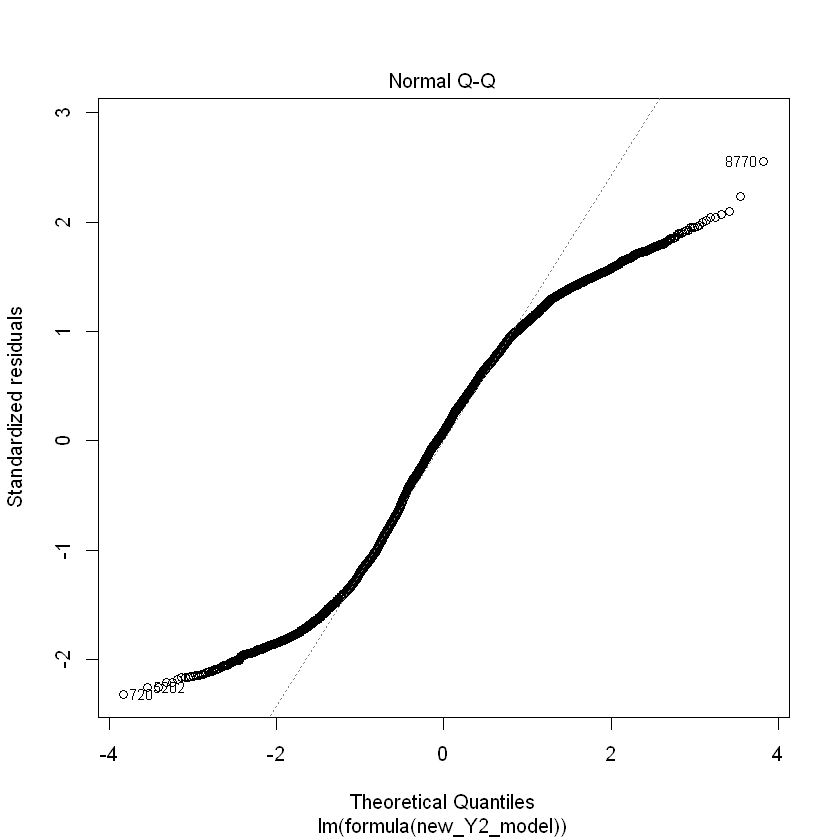

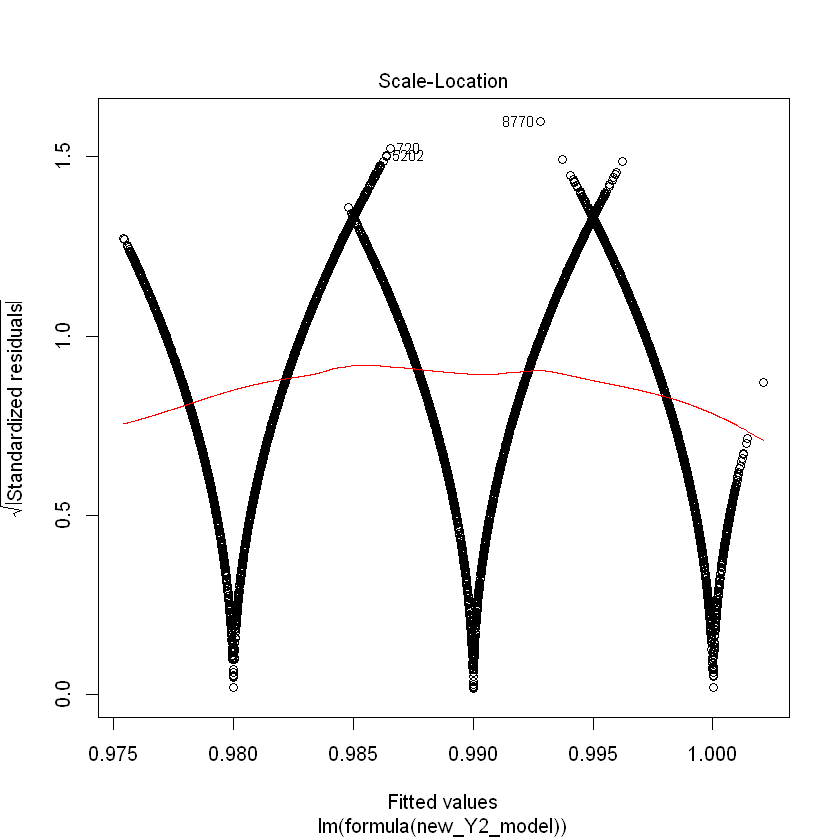

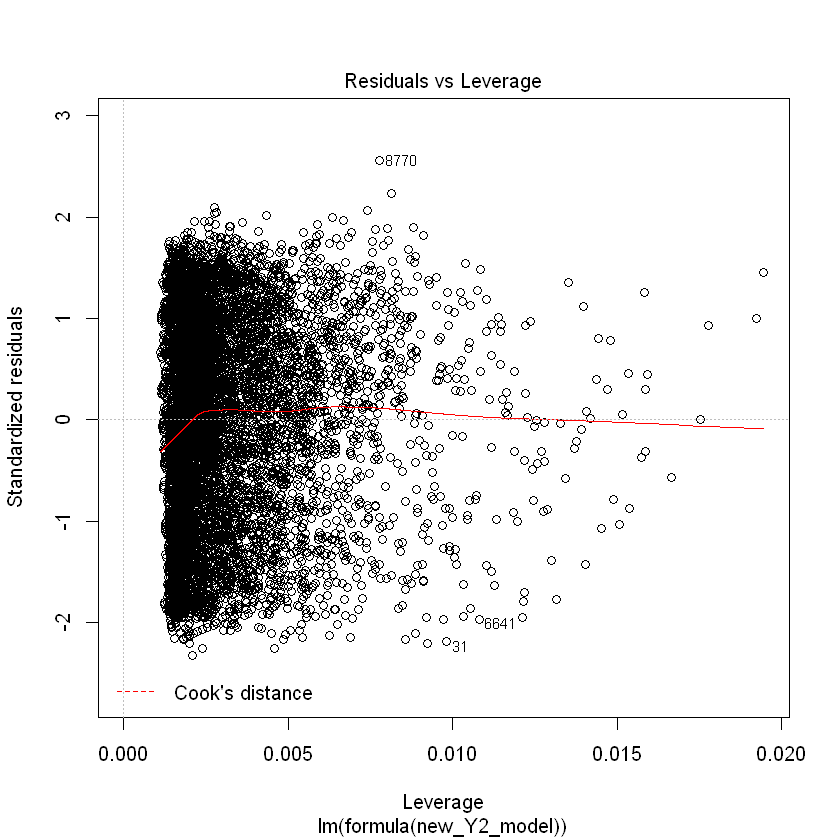

In [30]:
plot(clean_Y2_model)

<font color=blue>The discrete values of Y2 makes it difficult to observe if the values follow the model closely. 

In [31]:
test_data$Predicted_Y2 <- predict(clean_Y2_model, newdata = test_data)

max2 <- max(test_data$Predicted_Y2)
min2 <- min(test_data$Predicted_Y2)
interval2 <- (max(test_data$Predicted_Y2) - min(test_data$Predicted_Y2)) / 3
range2 <- c(1, 0.99, 0.98)
X2 = rep(0,3)
for (i in 1:3) {
    X2[i] = min2 + interval2*i
}
X2 <- append(X2, 1.2)
test_data$group_predicted_Y2 <- as.numeric(as.character(cut(test_data$Predicted_Y2, breaks = X2, labels = range2)))

<font color=green>Show test results 

In [32]:
summary(clean_Y2_model)


Call:
lm(formula = formula(new_Y2_model), data = train_data.clean)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0065569 -0.0022990  0.0002521  0.0023288  0.0072040 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.764e+02  3.151e+01   5.598 2.24e-08 ***
X1          -7.812e-01  7.390e-02 -10.570  < 2e-16 ***
X2           2.452e-01  2.251e-02  10.896  < 2e-16 ***
X3           2.213e-05  9.498e-07  23.298  < 2e-16 ***
X4          -4.428e-04  6.029e-05  -7.344 2.29e-13 ***
X5           2.903e-04  2.202e-05  13.182  < 2e-16 ***
X8           1.327e-04  1.405e-04   0.944   0.3451    
X10         -5.371e-03  5.986e-04  -8.972  < 2e-16 ***
X13         -1.093e-01  6.578e-03 -16.619  < 2e-16 ***
X14         -3.463e+02  6.189e+01  -5.595 2.28e-08 ***
X15         -9.126e-05  5.381e-05  -1.696   0.0899 .  
X16          9.087e-02  1.399e-02   6.497 8.72e-11 ***
I(X1^2)      1.853e-01  1.594e-02  11.623  < 2e-16 ***
I(X2^2)     -2.115e-02 

In [33]:
postResample(pred = test_data$group_predicted_Y2, obs = test_data$Y2)

RMSE    Rsquared         MAE 
0.010673036 0.516988623 0.009456845

<font color=blue>The R-squared value of the model tested with the training data is significantly better but falls short when it comes to predicting new data. Nonetheless, the RMSE value is especially low which is good news. 

## [Back to top](#Contents) 

# 6. Predicting Test Set

<font color=green>Lastly, we predict the response variables using our models on the second dataset provided.

<font color=green>Viewing test set

In [34]:
head(naval_test_data)

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16
5.14,15,21627.91,1924.32,8471.51,175.24,175.24,709.63,288,637.08,2.09,1,11.17,1.03,25.32,0.50
1.14,3,1419.85,1388.02,6671.01,9.72,9.72,483.83,288,552.49,1.15,1,6.19,1.02,0.47,0.10
8.21,24,50996.80,3087.59,9314.03,438.12,438.12,938.44,288,737.21,3.58,1,18.54,1.04,61.43,1.22
5.14,15,21637.73,1924.34,8505.35,175.32,175.32,710.67,288,640.85,2.08,1,11.00,1.03,25.22,0.50
3.14,9,8376.33,1386.74,7069.37,60.32,60.32,575.13,288,576.87,1.39,1,7.47,1.02,11.88,0.24
5.14,15,21623.73,1924.32,8461.20,175.20,175.20,695.24,288,631.94,2.09,1,11.13,1.03,24.58,0.49


<font color=green> Extract row 16 and predict its Y1 and Y2 value.

In [35]:
naval_test_data[16,]
print("-----------------PREDICTED Y1 CONFIDENCE INTERVAL-----------------")
predict(clean_Y1_model, newdata = naval_test_data[16,], interval = "confidence")
print("-----------------PREDICTED Y2 CONFIDENCE INTERVAL-----------------")
predict(clean_Y2_model, newdata = naval_test_data[16,], interval = "confidence")

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16
16,2.09,6,3735.67,1386.74,6790.89,30.04,30.04,520.73,288,561.89,1.24,1,6.66,1.02,0,0.15


[1] "-----------------PREDICTED Y1 CONFIDENCE INTERVAL-----------------"


,fit,lwr,upr
16,0.9814918,0.9811613,0.9818223


[1] "-----------------PREDICTED Y2 CONFIDENCE INTERVAL-----------------"


,fit,lwr,upr
16,0.9849494,0.9846229,0.9852758


<font color=blue>For the above values in row 16, we get a fitted value of Y1 as 0.9814 with a lower bound of 0.9811 and a higher bound of 0.9818. The same is done to predict Y2. 

<font color=green>Saving results to a .csv file

In [36]:
test_result_Y2 <- data.frame(predict(clean_Y2_model, newdata = naval_test_data))
write.csv(test_result_Y2, "C:/Users/delim/Desktop/Data Science for Biz/Assignment 1/assign1_PredY2_Values.csv", row.names = FALSE)

test_result_Y1 <- data.frame(predict(clean_Y1_model, newdata = naval_test_data))
write.csv(test_result_Y2, "C:/Users/delim/Desktop/Data Science for Biz/Assignment 1/assign1_PredY1_Values.csv", row.names = FALSE)

## [Back to top](#Contents) 

# 7. References

Kutner, M. H., Nachtsheim, C. J., Neter, J., & Li, W. (2005). Applied linear statistical models.

# 8. Grading Rubrics

10% : Basic exploration of the data -- things that we talked about in class, basic statistics, basic visualizations <br>
10% : Advanced exploration of the data -- any interesting observation on the dataset, or any data preparation <br>
10% : Basic linear modeling for predicting Y1 -- things that we talked about in class, best subset of variables <br>
10% : Advanced linear modeling for predicting Y1 -- anything extra, like non-linearity, interactions, outliers etc <br>
10% : Basic linear modeling for predicting Y2 -- things that we talked about in class, best subset of variables <br>
10% : Advanced linear modeling for predicting Y2 -- anything extra, like non-linearity, interactions, outliers etc <br>
10% : Overall presentation of the Rmdworksheet -- logical organization of analysis, comments, code, visuals etc<br>
10% : Prediction of Y1 and Y2 in the Pred dataset -- considering predicted values, and the appropriate intervals<br>
10% : Prediction accuracy of Y1 and Y2 -- I have the actual values of course, and you will be judged on RMSE <br>
10% : Reserved as "extra credit" in case of any out-of-the-box solution, observation, treatment in your work <br>

# 9. Using R in Jupyter Notebook

https://docs.anaconda.com/anaconda/navigator/tutorials/r-lang/